**Lab 1 - Time Series Trends**

Your name

[Harley & Firebaugh](https://https://www.jstor.org/stable/1386665) in 1993 wrote, "the most interesting thing about belief in an afterlife in the United States is what it is not doing: It is not declining."  But that was a long time ago, so it is worth seeing if now, over the more recent two decades, belief in the afterlife has begun decline.  They looked at age and cohort to understand the trends, but we will look at people who identify with a religion vs. saying they are part of no religion.

Here we will load in some packages and also load in the GSS data directly from the website.  We will create two sets of variables.  One set will use numeric value lables for the variables, while the other set will be categorical names for the labels (these will be prefaced with a z in front of each variable).   This is a very complicated dataset to load in, so I create a bunch of code to do some things to it ... please don't worry about them for now.  Just enjoy working with the dataset!

In [ ]:
import pandas as pd
import requests
import zipfile
import io
from tqdm.notebook import tqdm

In [ ]:
# Step 1: Download the ZIP file with progress bar
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/GSS_stata.zip'

# Make a streaming request to get the content in chunks
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # Get the total file size
block_size = 1024  # 1 Kilobyte

# Progress bar for downloading
tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

# Download the file in chunks with progress bar
for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

# Check if the download is successful
if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file.")
else:
    print("Download completed!")

# Step 2: Extract the ZIP file in memory and display progress
with zipfile.ZipFile(content) as z:
    # List all files in the zip
    file_list = z.namelist()

    # Filter for the .dta file (assuming there is only one)
    stata_files = [file for file in file_list if file.endswith('.dta')]

    # If there is a Stata file, proceed to extract and read it
    if stata_files:
        stata_file = stata_files[0]  # Take the first .dta file
        with z.open(stata_file) as stata_file_stream:
            # Step 3a: Load only the selected columns into a pandas DataFrame with numeric labels
            columns_to_load = ['id', 'degree', 'marital', 'sex', 'year', 'age', 'region', 'life', 'suicide1', 'marhomo']
            print("Loading selected columns from Stata file with numeric labels...")
            df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
            print("Data with numeric labels loaded successfully!")

        # Reload the dataset to get categorical (string) labels
        with z.open(stata_file) as stata_file_stream:
            print("Loading selected columns from Stata file with string (categorical) labels...")
            df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
            print("Data with categorical labels loaded successfully!")

            # Step 3b: Rename the categorical columns by prefixing with 'z' (no period)
            df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})

# Step 4: Concatenate the numeric and categorical DataFrames side by side
df = pd.concat([df_numeric, df_categorical], axis=1)

# Step 5: Display the first few rows of the final DataFrame
df.head()

  0%|          | 0.00/81.9M [00:00<?, ?iB/s]

Download completed!
Loading selected columns from Stata file with numeric labels...
Data with numeric labels loaded successfully!
Loading selected columns from Stata file with string (categorical) labels...


<ipython-input-20-cbdf6aa4c853>:47: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)


Data with categorical labels loaded successfully!


,id,degree,marital,sex,year,age,region,life,suicide1,marhomo,zid,zdegree,zmarital,zsex,zyear,zage,zregion,zlife,zsuicide1,zmarhomo
0,1,3.0,5.0,2.0,1972,23.0,3,NaN,NaN,NaN,1,bachelor's,never married,female,1972,23.0,east north central,NaN,NaN,NaN
1,2,0.0,1.0,1.0,1972,70.0,3,NaN,NaN,NaN,2,less than high school,married,male,1972,70.0,east north central,NaN,NaN,NaN
2,3,1.0,1.0,2.0,1972,48.0,3,NaN,NaN,NaN,3,high school,married,female,1972,48.0,east north central,NaN,NaN,NaN
3,4,3.0,1.0,2.0,1972,27.0,3,NaN,NaN,NaN,4,bachelor's,married,female,1972,27.0,east north central,NaN,NaN,NaN
4,5,1.0,1.0,2.0,1972,61.0,3,NaN,NaN,NaN,5,high school,married,female,1972,61.0,east north central,NaN,NaN,NaN


In [ ]:
from __future__ import division
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

**1. Conduct a trend analysis of some variable of interest. Graph it and try different functional forms. Look for subgroup variation across time, too. Extra credit if you consider other variables as a means of explaining the trend. Explain all of your results.**

I will begin by examining what the overall trend in belief in the afterlife has been for the last 50 years.  

NOTE: I subset my dataset to only include observations that are not missing on any of the following: 'year', 'relig', postlife' -- that is what the dataframe "df_clean" is.

In [ ]:
# Step 1: Drop observations with NA values in any variable listed
df_clean = df.dropna(subset=['year', 'life', 'suicide1', 'marhomo'])
df_clean.head()


,id,degree,marital,sex,year,age,region,life,suicide1,marhomo,zid,zdegree,zmarital,zsex,zyear,zage,zregion,zlife,zsuicide1,zmarhomo
21879,5,3.0,5.0,1.0,1988,25.0,2,1.0,1.0,4.0,5,bachelor's,never married,male,1988,25.0,middle atlantic,exciting,yes,disagree
21882,8,1.0,3.0,2.0,1988,27.0,2,2.0,1.0,2.0,8,high school,divorced,female,1988,27.0,middle atlantic,routine,yes,agree
21884,10,0.0,5.0,1.0,1988,50.0,2,2.0,2.0,4.0,10,less than high school,never married,male,1988,50.0,middle atlantic,routine,no,disagree
21886,12,0.0,1.0,1.0,1988,24.0,2,1.0,2.0,4.0,12,less than high school,married,male,1988,24.0,middle atlantic,exciting,no,disagree
21891,17,3.0,5.0,2.0,1988,30.0,2,2.0,1.0,4.0,17,bachelor's,never married,female,1988,30.0,middle atlantic,routine,yes,disagree


In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='marhomo', data=mean_marhomo_per_year)
plt.title('Proportion of People Who Say "Yes, Same-Sex Marriage" Per Year (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.grid(True)
plt.show()


ValueError: Could not interpret value `marhomo` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

This appears to show something of an upward trajectory on this trend over time, meaning more people are believing in the afterlife now than 50 years ago.  This is not what would be theorized, based on the previous studies!

In [ ]:
df_clean.groupby('year')['natarms'].apply(lambda x: (x == 'yes').mean() * 100).reset_index()

,year,zpostlife
0,1973,76.979472
1,1975,74.533234
2,1976,78.248175
3,1978,76.740847
4,1980,81.245254
5,1983,73.623385
6,1984,79.451039
7,1986,81.938326
8,1987,77.904192
9,1988,79.416058


In [ ]:
# Step 1: Run the regression using the formula interface
model0 = smf.ols(formula='zpostlife_binary ~ year', data=df_clean)

# Step 2: Fit the model
results0 = model0.fit()

# Step 3: Output the summary of the regression
print(results0.summary())

                            OLS Regression Results                            
Dep. Variable:       zpostlife_binary   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     48.69
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           3.04e-12
Time:                        18:47:16   Log-Likelihood:                -22049.
No. Observations:               43985   AIC:                         4.410e+04
Df Residuals:                   43983   BIC:                         4.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0848      0.270     -4.015      0.0

If we simply include a linear time trend, we see that it is quite statistically signifacant, such that for each year that goes by, the percentage of people who say they believe in the afterlife goes up by 0.09 percentage points per year.  This is quite statistically significant, though the R-sq is quite small, with time explaining only 0.1% of all variation in belief in the afterlife.

In [ ]:
# Step 1: Run the regression using the formula interface
model = smf.ols(formula='zpostlife_binary ~ C(year)', data=df_clean)

# Step 2: Fit the model
results = model.fit()

# Step 3: Output the summary of the regression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       zpostlife_binary   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.260
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.54e-17
Time:                        18:47:19   Log-Likelihood:                -22002.
No. Observations:               43985   AIC:                         4.406e+04
Df Residuals:                   43957   BIC:                         4.430e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7698      0.011     

If we include year dummies in the model instead, we see that most of the years, especially after 1993, are statistically different from the first year of data in 1973.  In fact, in 2022, 4.2 percentage points more people said they believed in the afterlife, compared to in 1973 -- and this difference appears statistically significant.  For what it is worth, the Rsq tripled to 0.3% being explainable by year dummies.

I then turned to look for subgroup variation across time, too.  I looked at whether there are differences in the trends for people who identify with a religion vs. saying they are part of no religion.  I would think that those who do not identify with a religion might not share a belief in the afterlife.

<ipython-input-35-1807c416f723>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['norelig_binary'] = np.select(relig_conditions, relig_choices, default=np.nan)


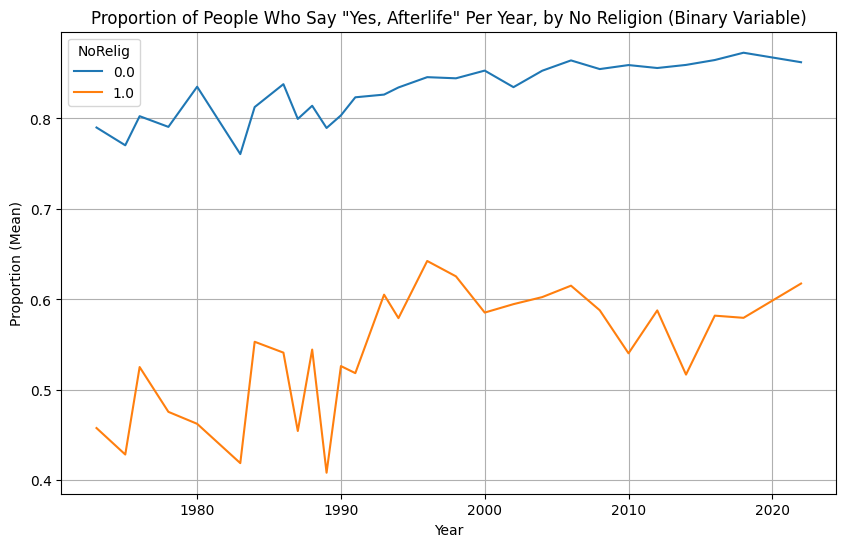

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define conditions and choices for the  variable
relig_conditions = [
    (df_clean['relig'] == 4),  # 4 is "no religion"
    (df_clean['relig'] != 4)    # everything else is a religion
]

relig_choices = [1, 0]  # 1 if relig==4, otherwise 0

# Step 2: Use np.select to create a new binary variable based on the conditions
df_clean['norelig_binary'] = np.select(relig_conditions, relig_choices, default=np.nan)

# Step 3: Calculate the mean of the new binary variable by year and relig group
mean_postlife_per_year_norelig = df_clean.groupby(['year', 'norelig_binary'])['zpostlife_binary'].mean().reset_index()

# Step47: Plot the mean of the binary  variable by year, split by relig
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='zpostlife_binary', hue='norelig_binary', data=mean_postlife_per_year_norelig)
plt.title('Proportion of People Who Say "Yes, Afterlife" Per Year, by No Religion (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.legend(title='NoRelig')  # Automatically create the legend based on hue
plt.grid(True)
plt.show()



Not surprisingly, those with no religion are much less likely to believe in the afterlife (usually approximately 30 percentage points lower than those who do say they have a religion), but the trends look pretty similar.  Those without religion have increased their belief in the afterlife too!  And by a margin similar to those with a religion, or at least that is what it looks like from the graph.

In [ ]:
model2 = smf.ols(formula='zpostlife_binary ~ year + norelig_binary', data=df_clean)

# Step 1: Fit the model
results2 = model2.fit()

# Step 2: Output the summary of the regression
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:       zpostlife_binary   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1216.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:47:27   Log-Likelihood:                -20889.
No. Observations:               43985   AIC:                         4.178e+04
Df Residuals:                   43982   BIC:                         4.181e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0174      0.266    -11.

We see that on average, a person without religion is expected to say they believe in an afterlife by .28 percentage points, net of year.  That upped the Rsq considerable, to 5.2% variation explained now.

In [ ]:
model3 = smf.ols(formula='zpostlife_binary ~ year*norelig_binary', data=df_clean)

# Step 1: Fit the model
results3 = model3.fit()

# Step 2: Output the summary of the regression
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:       zpostlife_binary   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     811.1
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:47:30   Log-Likelihood:                -20889.
No. Observations:               43985   AIC:                         4.179e+04
Df Residuals:                   43981   BIC:                         4.182e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.9416    

When we interact year with "no religion" we see that the interaction is not statistically significant (P>|t| of .428), suggesting that the two groups are increasing their belief in the afterlife at the same rate.

So our big conclusion is that no one really would have predicted this!  Harley & Firebaugh has expected that that belief in an afterlife in the United States would have been declining, but they found that belief was flat.  Now, 30 years later, we see that it is not even just flat anymore ... it is actually increasing, and not just for those who have a religion, but for those without a religion too.  Fascinating!